In [ ]:
from dustbi_simulator import *
from Functions import *

In [47]:
import numpy as np
import pandas as pd
df = pd.read_csv("INPUT_DES5YR_D2D.FITRES", comment="#", sep='\s+')

df['SIM_EBV'] = df.SIM_AV/df.SIM_RV


dfdata = pd.read_csv("SIMS_FOR_TESTING/FITOPT000.FITRES.gz", 
                     comment="#", sep=r'\s+')

#dfdata = pd.read_csv("../INVERSE_H0/D5YR_DATA/FITOPT000_MUOPT000.FITRES.gz", comment="#", sep=r'\s+')

try:
    dfdata['SIM_EBV'] = dfdata.SIM_AV/dfdata.SIM_RV
except:
    print("eh.")

dfdata = dfdata.loc[dfdata.IDSURVEY == 10]
dfdata = dfdata.loc[dfdata.PROB_SNNV19 >= 0.5]

In [48]:
bounds_dict = {
    "SIM_c"   : (-0.5, 0.5),
    "SIM_RV"  : (1.5, 5),
    "SIM_EBV" : (0,1),
    "SIM_beta": (0.5,4),
}

function_dict = {
    "SIM_c"   : DistGaussian,
    "SIM_RV"  : DistGaussian,
    "SIM_EBV" : DistExponential,
    "SIM_beta": DistGaussian,
}

split_dict = {
#    "SIM_RV":["HOST_LOGMASS", 10],
    "SIM_EBV":['HOST_LOGMASS', 10],
#    'SIM_c':['HOST_LOGMASS', 10]
}


#Prior dict is a weird one; it should be a tuple for each parameter and then a boolean statement.

#split_dict = {}


priors_dict = {
    
    "SIM_c"   : [(-0.2, 0), (0.0, 0.1), False],
    "SIM_RV"  : [(1.5,4), (0,2), True],
    "SIM_EBV" : [(0.05, 0.3)],
    "SIM_beta": [(0,3), (0,1), True],
    
}

latex_dict = {
    
    'DistExponential':[r'$\tau$'],
    'DistGaussian':[r'$\mu$', r'$\sigma$'],
    'SIM_c':r"$c_{\rm int}$",
    'SIM_beta':r"$\beta_{\rm int}$",
    'SIM_RV':r"$R_V$",
    'SIM_EBV':r"$EBV$",
    
}


dicts = [bounds_dict, function_dict, split_dict, priors_dict]

In [70]:
param_names = ['SIM_c', 'SIM_RV', 'SIM_beta', 'SIM_EBV']
#param_names = ['SIM_c']


params_to_fit = parameter_generation(param_names, dicts)
priors = prior_generator(param_names, dicts)

Total priors added: 8
[0] <class 'sbi.utils.torchutils.BoxUniform'>
[1] <class 'sbi.utils.torchutils.BoxUniform'>
[2] <class 'sbi.utils.torchutils.BoxUniform'>
[3] <class 'sbi.utils.torchutils.BoxUniform'>
[4] <class 'sbi.utils.torchutils.BoxUniform'>
[5] <class 'sbi.utils.torchutils.BoxUniform'>
[6] <class 'sbi.utils.torchutils.BoxUniform'>
[7] <class 'sbi.utils.torchutils.BoxUniform'>


In [71]:
layout = build_layout(params_to_fit, dicts)

In [72]:
parameters_to_condition_on = ['c', 'mB', 'x1', 'zHD']

In [73]:
simulatinator = make_simulator(layout, df, param_names, parameters_to_condition_on, dicts, dfdata, is_split=True)


Found a split in dict_keys(['SIM_EBV'])


In [74]:
ndim = len(parameters_to_condition_on)

if any(p in split_dict for p in param_names): #check early to see if we need to split anything. 
    ndim *= 2
    
print(ndim)

8


In [75]:
def batched_simulator(theta_batch):
    return torch.stack([simulatinator(theta) for theta in theta_batch])

In [76]:
from sbi import analysis as analysis

# sbi
from sbi import utils as utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [77]:
# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(priors)
simulation_wrapper = process_simulator(simulatinator, prior, prior_returns_numpy)
check_sbi_inputs(simulation_wrapper, prior)

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F




In [79]:
from sbi.inference import SNPE
from sbi.utils import MultipleIndependent

from sbi.neural_nets import posterior_nn




# Potentially Upgraded Version

In [80]:
class PopulationEmbeddingFull(nn.Module):
    def __init__(self, input_dim=ndim, hidden_dim=64, output_dim=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (batch_size, N, 2)
        h = self.phi(x)           # (batch_size, N, hidden_dim)
        h = h.mean(dim=1)         # mean over N samples -> (batch_size, hidden_dim)
        return self.rho(h)        # (batch_size, output_dim)


In [81]:
from sbi.inference import SNPE
from sbi.utils import MultipleIndependent

from sbi.neural_nets import posterior_nn

density_estimator = posterior_nn(
    model="nsf", #switch to nsf if interested 
    embedding_net=PopulationEmbeddingFull(input_dim=ndim)
)

inference = SNPE(
    prior=priors,
    density_estimator=density_estimator, 
)





In [82]:
import torch
import os
import time


start = time.perf_counter()

batch_size = 300
num_simulations = 10000
save_path = "simulations_v1.pt"

# If the file already exists, start fresh
if os.path.exists(save_path):
    os.remove(save_path)

for start in range(0, num_simulations, batch_size):
    current_bs = min(batch_size, num_simulations - start)

    # Sample and simulate
    theta_batch = priors.sample((current_bs,))
    x_batch = batched_simulator(theta_batch)

    # Append to SBI inference
    inference.append_simulations(theta_batch, x_batch)

    # Save incrementally
    if start == 0:
        # First batch, create the file
        torch.save({'theta': theta_batch, 'x': x_batch}, save_path)
    else:
        # Load existing data
        data = torch.load(save_path)
        data['theta'] = torch.cat([data['theta'], theta_batch], dim=0)
        data['x'] = torch.cat([data['x'], x_batch], dim=0)
        torch.save(data, save_path)

    print(f"Appended {start + current_bs}/{num_simulations} simulations and saved incrementally.")

print(f"All simulations saved incrementally to '{save_path}'")

end = time.perf_counter()

elapsed = end - start
#print(f'Time taken: {elapsed:.6f} seconds')

Appended 300/10000 simulations and saved incrementally.


/var/folders/2p/hm6bd5n17d5g5kpsm6s7vf3r0002g2/T/ipykernel_17423/2828413460.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(save_path)


Appended 600/10000 simulations and saved incrementally.


Appended 900/10000 simulations and saved incrementally.


Appended 1200/10000 simulations and saved incrementally.


Appended 1500/10000 simulations and saved incrementally.


Appended 1800/10000 simulations and saved incrementally.


Appended 2100/10000 simulations and saved incrementally.


Appended 2400/10000 simulations and saved incrementally.


Appended 2700/10000 simulations and saved incrementally.


Appended 3000/10000 simulations and saved incrementally.


Appended 3300/10000 simulations and saved incrementally.


Appended 3600/10000 simulations and saved incrementally.


Appended 3900/10000 simulations and saved incrementally.


Appended 4200/10000 simulations and saved incrementally.


Appended 4500/10000 simulations and saved incrementally.


Appended 4800/10000 simulations and saved incrementally.


Appended 5100/10000 simulations and saved incrementally.


Appended 5400/10000 simulations and saved incrementally.


Appended 5700/10000 simulations and saved incrementally.


Appended 6000/10000 simulations and saved incrementally.


Appended 6300/10000 simulations and saved incrementally.


Appended 6600/10000 simulations and saved incrementally.


Appended 6900/10000 simulations and saved incrementally.


Appended 7200/10000 simulations and saved incrementally.


Appended 7500/10000 simulations and saved incrementally.


Appended 7800/10000 simulations and saved incrementally.


Appended 8100/10000 simulations and saved incrementally.


Appended 8400/10000 simulations and saved incrementally.


Appended 8700/10000 simulations and saved incrementally.


Appended 9000/10000 simulations and saved incrementally.


Appended 9300/10000 simulations and saved incrementally.


Appended 9600/10000 simulations and saved incrementally.


Appended 9900/10000 simulations and saved incrementally.


Appended 10000/10000 simulations and saved incrementally.
All simulations saved incrementally to 'simulations_v1.pt'


In [83]:
print(f'Time taken: {elapsed/60:.6f} minutes')

Time taken: 4532.534228 minutes


In [84]:
#inference.append_simulations(theta_batch, x_batch)

density_estimator = inference.train()

print("\n inferred successfully")

posterior = inference.build_posterior(density_estimator)

torch.save(posterior, "posterior.pt")


 Neural network successfully converged after 167 epochs.
 inferred successfully


In [ ]:
data = torch.load("simulations_v1.pt")
theta_batch = data["theta"]
x_batch = data["x"]


In [85]:
def preprocess_data(param_names, parameters_to_condition_on, split_dict, dfdata, ):
    
    output_distribution = preprocess_input_distribution(dfdata, parameters_to_condition_on)

    if any(p in split_dict for p in param_names):
        is_split = True#check early to see if we need to split anything. 
    
    if is_split:
    
        matching = [p for p in param_names if p in split_dict]
        name = matching[0]

        split_param = split_dict[name][0]
        split_val   = split_dict[name][1]

        split_tensor = torch.tensor(
            dfdata[split_param].to_numpy(),
            dtype=torch.float32,
            )

        x = split_outputs(
            output_distribution,
            split_tensor,
            split_val,
            parameters_to_condition_on
            )

    else:
        x = torch.stack(
            [output_distribution[p] for p in parameters_to_condition_on],
            dim=-1
        )
        
    return x 

In [86]:
x = preprocess_data(param_names, parameters_to_condition_on, split_dict, dfdata)



In [87]:
labels = unspool_labels(param_names, dicts, latex_dict, function_dict)

In [89]:
posterior_samples = posterior.sample((50000,), x=x)


50616it [00:00, 195711.92it/s]                                                  


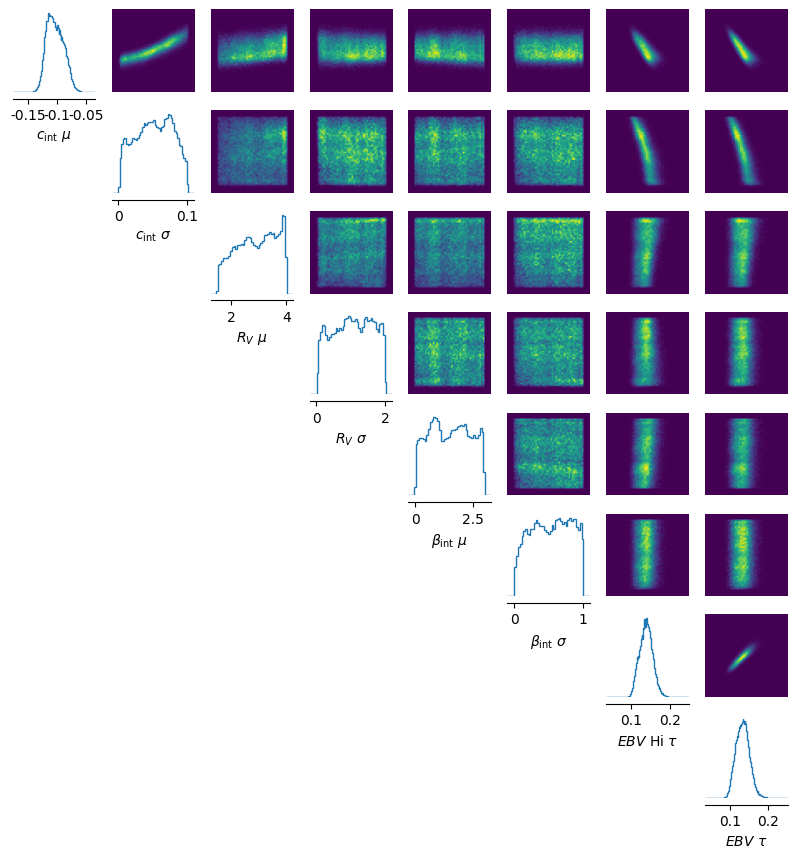

In [90]:
fig, axes = analysis.pairplot(
    posterior_samples,
    labels=labels

);

In [91]:
theta_hat = posterior_samples.mean(0)


In [92]:
theta_hat


tensor([-0.1032,  0.0512,  2.8926,  1.0422,  1.5085,  0.5309,  0.1385,  0.1317])

In [93]:
posterior_samples.std(0)

tensor([0.0144, 0.0261, 0.7018, 0.5525, 0.8507, 0.2761, 0.0168, 0.0173])

In [94]:
true_params = torch.tensor([-0.07, 0.053, 2, 0.95, 2.07, 0.22, 0.15, 0.12,])

In [95]:
from IPython.display import display, Math


In [96]:
for n in range(len(theta_hat)):
    

    delta = theta_hat[n] - true_params[n]
    sigma = delta/posterior_samples.std(0)[n]
    
    string = rf"{labels[n]} = {theta_hat[n]:.3f} +/- {posterior_samples.std(0)[n]:.3f} which is {sigma:.3f} $\sigma$"
    
    display(Math(string))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [65]:
simulatinator = make_simulator(layout, df, param_names, parameters_to_condition_on, dicts, 
                               dfdata, is_split=True, debug=True)


Found a split in dict_keys(['SIM_EBV'])


In [67]:
#dft = simulatinator(theta_hat)

dft = simulatinator(torch.tensor([[-0.1006,  0.0507,  2.7590,  1.0042,  1.4923,  0.5086,  0.3, 0.06]]))

In [68]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'c')

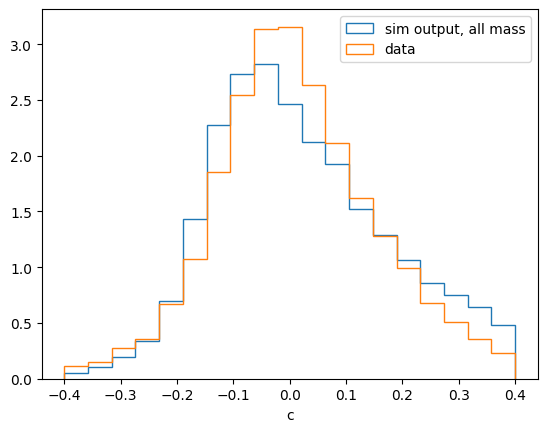

In [43]:
bins = np.linspace(-0.4, 0.4, 20)

#plt.hist(dft.loc[dft.HOST_LOGMASS < 10].c.values, histtype='step', bins=bins, label="sim output, low mass", density=True)
#plt.hist(dft.loc[dft.HOST_LOGMASS > 10].c.values, histtype='step', bins=bins, label="sim output, high mass", density=True)
plt.hist(dft.c.values, histtype='step', bins=bins, label="sim output, all mass", density=True)

plt.hist(dfdata.c.values, histtype='step', bins=bins, label="data", density=True)

plt.legend()
plt.xlabel("c")

Text(0.5, 0, 'mB')

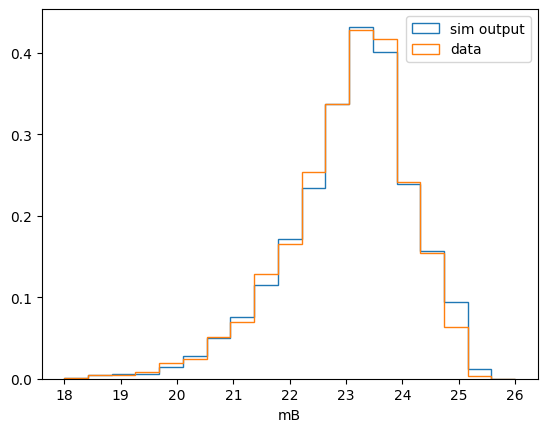

In [44]:
bins = np.linspace(18, 26, 20)

plt.hist(dft.mB.values, histtype='step', bins=bins, label="sim output", density=True)
plt.hist(dfdata.mB.values, histtype='step', bins=bins, label="data", density=True)

plt.legend()
plt.xlabel("mB")

Text(0.5, 0, 'E(B-V)')

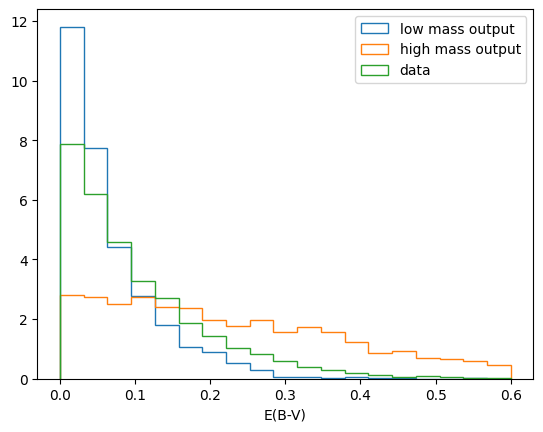

In [69]:
bins = np.linspace(0, 0.6, 20)

plt.hist(dft.loc[dft.HOST_LOGMASS < 10].SIM_EBV.values, histtype='step', bins=bins, label="low mass output", density=True)
plt.hist(dft.loc[dft.HOST_LOGMASS > 10].SIM_EBV.values, histtype='step', bins=bins, label="high mass output", density=True)


plt.hist(dfdata.SIM_EBV.values, histtype='step', bins=bins, label="data", density=True)


plt.legend()
plt.xlabel("E(B-V)")

# Calibrate some posteriors

In [ ]:
num_calib = 500  
ranks = []

for _ in range(num_calib):
    
    theta_true = priors.sample((1,)) 
    
    x_sim = simulatinator(theta_true)
    
    x_sim = simulatinator(theta_true)

    if torch.isnan(x_sim).any():
        continue  # skip this calibration draw


    posterior = inference.build_posterior(density_estimator)
    samples = posterior.sample((200,), x=x_sim)


    # Compute rank of true parameter in the posterior samples
    for i in range(theta_true.shape[1]):
        rank_i = (samples[:, i] < theta_true[0, i]).float().mean()
        ranks.append(rank_i.item())

import matplotlib.pyplot as plt
plt.hist(ranks, bins=20)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("SBC Histogram")
plt.show()

In [ ]:
#Flat histogram → well-calibrated.

#U-shaped → posteriors too narrow.

#Bell-shaped → posteriors too wide.

In [ ]:
import matplotlib.pyplot as plt